<a href="https://colab.research.google.com/github/kodai-utsunomiya/memorization-and-generalization/blob/main/numerical_experiments/exp_4/exp_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 必要なもの

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim

class BinaryDataset:
    def __init__(self, n, k, train_size, test_size, data_seed, normalize=False, device=None):
        """
        BinaryDatasetクラスのコンストラクタ

        Parameters:
        - n: バイナリ文字列の長さ
        - k: 出力ラベルの計算に使用する最初の k 個のビット
        - train_size: 訓練データのサイズ
        - test_size: テストデータのサイズ
        - data_seed: ランダムシード
        - normalize: データを正規化するかどうかを示すフラグ
        - device: データを移動するデバイス
        """
        self.n = n
        self.k = k
        self.train_size = train_size
        self.test_size = test_size
        self.data_seed = data_seed
        self.normalize = normalize
        self.device = device

        # データの準備
        (self.train_inputs, self.train_outputs), (self.test_inputs, self.test_outputs) = self._prepare_data()

    def _prepare_data(self):
        """
        データの準備を行うメソッド

        Returns:
        - tuple: ((訓練データのx, 訓練データのy), (テストデータのx, テストデータのy))
        """
        np.random.seed(self.data_seed)
        total_size = self.train_size + self.test_size

        # ユニークなバイナリ文字列を生成
        binary_strings = {tuple(np.random.randint(2, size=self.n)) for _ in range(total_size)}
        while len(binary_strings) < total_size:
            binary_strings.add(tuple(np.random.randint(2, size=self.n)))

        binary_strings = list(binary_strings)
        inputs = np.array(binary_strings, dtype=np.float32)
        outputs = np.sum(inputs[:, :self.k], axis=-1) % 2

        # # 出力ラベルを 0 -> -1, 1 -> 1 に変換（ヒンジ損失用）
        # outputs = 2 * outputs - 1

        # データの正規化を行う場合
        if self.normalize:
            # 中心化（平均を0に）
            inputs = (inputs - inputs.mean(axis=0))
            # 標準化（各サンプルのノルムで割る）．データが単位ノルムを持つようにスケーリング
            norm = np.linalg.norm(inputs, axis=1, keepdims=True)
            inputs = (inputs / np.maximum(norm, 1e-8))  # ゼロ除算防止

        # インデックスをシャッフルして訓練データとテストデータを分割
        indices = np.random.permutation(total_size)
        train_indices, test_indices = indices[:self.train_size], indices[self.train_size:]

        # NumPy配列からPyTorchテンソルに変換，デバイスに移動
        train_inputs = torch.tensor(inputs[train_indices], dtype=torch.float32).to(self.device)
        train_outputs = torch.tensor(outputs[train_indices], dtype=torch.float32).to(self.device)
        test_inputs = torch.tensor(inputs[test_indices], dtype=torch.float32).to(self.device)
        test_outputs = torch.tensor(outputs[test_indices], dtype=torch.float32).to(self.device)

        return (train_inputs, train_outputs), (test_inputs, test_outputs)

    def get_data(self):
        """
        データセットを取得するメソッド

        Returns:
        - tuple: ((訓練データのx, 訓練データのy), (テストデータのx, テストデータのy))
        """
        return (self.train_inputs, self.train_outputs), (self.test_inputs, self.test_outputs)


####################################################

import functools
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

class FC(nn.Module):
    def __init__(self, d, h, L, act, bias=False):
        super().__init__()

        # ネットワークの初期化
        hh = d  # 入力の次元数
        for i in range(L):
            # 隠れ層の重み行列を正規分布で初期化
            W = torch.randn(h, hh)

            # メモリ効率を考慮し，重み行列を部分行列に分割して ParameterList に格納
            # next two line are here to avoid memory issue when computing the kerne
            n = max(1, 128 * 256 // hh)  # 分割サイズを計算
            W = nn.ParameterList([nn.Parameter(W[j: j+n]) for j in range(0, len(W), n)])

            # 分割した重み行列をレイヤーとして登録
            setattr(self, "W{}".format(i), W)

            # バイアス項が指定されている場合は，それをゼロで初期化して登録
            if bias:
                self.register_parameter("B{}".format(i), nn.Parameter(torch.zeros(h)))

            # 次のレイヤーの入力次元は現在の隠れ層のユニット数になる
            hh = h

        # 最終層の重み行列を初期化（出力がスカラー値なので次元は (1, h)）
        self.register_parameter("W{}".format(L), nn.Parameter(torch.randn(1, hh)))

        # バイアス項が指定されている場合は，最終層のバイアスをゼロで初期化
        if bias:
            self.register_parameter("B{}".format(L), nn.Parameter(torch.zeros(1)))

        # クラス変数としてレイヤー数，活性化関数，バイアスの有無を保持
        self.L = L
        self.act = act
        self.bias = bias

    def forward(self, x):
        # 順伝播計算
        for i in range(self.L + 1):
            # i 番目の層の重み行列を取得
            W = getattr(self, "W{}".format(i))

            # ParameterList 形式の重み行列をフルの行列に結合
            if isinstance(W, nn.ParameterList):
                W = torch.cat(list(W))

            # バイアス項が指定されている場合は，バイアスを取得
            if self.bias:
                B = self.bias * getattr(self, "B{}".format(i))
            else:
                B = 0

            # 現在の入力の次元数を取得
            h = x.size(1)

            if i < self.L:
                # 隠れ層での線形変換とスケーリング，そして活性化関数の適用
                x = x @ (W.t() / h ** 0.5)  # 重み行列との積（次元スケーリング）
                x = self.act(x + B)  # バイアス項を加えた後，活性化関数を適用
            else:
                # 最終層での線形変換（出力はスカラー値）
                x = x @ (W.t() / h ** 0.5) + B  # スカラー出力

        # 出力を 1 次元のテンソルに変換して返す
        return x.view(-1)

############################################

class LossFunctions:
    def __init__(self, model, weight_decay, reg_type=None, alpha=1.0, f0=False):
        self.model = model
        self.weight_decay = weight_decay
        self.reg_type = reg_type
        self.alpha = alpha
        self.f0 = f0

        # 学習開始時のモデルパラメータを保存
        if self.f0:
            self.initial_params = {name: param.clone() for name, param in self.model.named_parameters()}
        else:
            self.initial_params = None

    def binary_cross_entropy_with_logits(self, outputs, targets):
        sigmoid_outputs = torch.sigmoid(outputs)
        bce_loss = - (targets * torch.log(sigmoid_outputs + 1e-10) + (1 - targets) * torch.log(1 - sigmoid_outputs + 1e-10))
        return bce_loss.mean()

    def hinge_embedding_loss(self, outputs, targets):
        targets = 2 * targets - 1  # Convert 0/1 labels to -1/1
        hinge_loss = torch.clamp(1 - targets * outputs, min=0)
        return hinge_loss.mean()

    def mean_squared_error(self, outputs, targets):
        mse_loss = torch.mean((outputs - targets) ** 2)
        return mse_loss

    def regularization_loss(self):
        if self.reg_type is None:
            return 0
        elif self.reg_type == 'l1':
            return self.weight_decay * sum(param.abs().sum() for param in self.model.parameters())
        elif self.reg_type == 'l2':
            return self.weight_decay * sum(param.pow(2.0).sum() for param in self.model.parameters())
        else:
            raise ValueError('Unknown regularization type')

    def compute_loss(self, loss_fn_name, outputs, targets, inputs=None):
        if self.f0:
            if inputs is None:
                raise ValueError('Inputs must be provided when f0 is True')

            # 初期パラメータでの出力を計算
            initial_outputs = self._compute_model_outputs(self.initial_params, inputs)

            # 損失関数の計算
            if loss_fn_name == 'cross_entropy':
                loss = self.binary_cross_entropy_with_logits(self.alpha * (outputs - initial_outputs), targets)
            elif loss_fn_name == 'hinge':
                loss = self.hinge_embedding_loss(self.alpha * (outputs - initial_outputs), targets)
            elif loss_fn_name == 'mse':
                loss = self.mean_squared_error(self.alpha * (outputs - initial_outputs), targets)
            else:
                raise ValueError('Unknown loss function')

        else:
            # f0 が False の場合の損失関数
            if loss_fn_name == 'cross_entropy':
                loss = self.binary_cross_entropy_with_logits(outputs, targets)
            elif loss_fn_name == 'hinge':
                loss = self.hinge_embedding_loss(outputs, targets)
            elif loss_fn_name == 'mse':
                loss = self.mean_squared_error(outputs, targets)
            else:
                raise ValueError('Unknown loss function')

        return (loss / (self.alpha ** 2)) + self.regularization_loss()

    def _compute_model_outputs(self, params, inputs):
        # 初期パラメータでモデルの出力を計算するヘルパー関数
        with torch.no_grad():
            old_params = {name: param.clone() for name, param in self.model.named_parameters()}
            for name, param in params.items():
                self.model.state_dict()[name].copy_(param)
            outputs = self.model(inputs)
            # パラメータを元に戻す
            for name, param in old_params.items():
                self.model.state_dict()[name].copy_(param)
        return outputs

########################################

# 活性化関数取得
def get_activation(act_name):
    if act_name == 'relu':
        return lambda x: 2 ** 0.5 * torch.relu(x)
    elif act_name == 'tanh':
        return torch.tanh
    else:
        raise ValueError('act not specified')

# オプティマイザ取得
def get_optimizer(optimizer_name, model, hyper):
    if optimizer_name == 'sgd':
        return optim.SGD(model.parameters(), lr=hyper.learning_rate)
    elif optimizer_name == 'vanilla_gd':
        return None
    elif optimizer_name == 'adam':
        return optim.Adam(model.parameters(), lr=hyper.learning_rate, betas=[hyper.b1, hyper.b2])
    elif optimizer_name == 'adamw':
        return optim.AdamW(model.parameters(), lr=hyper.learning_rate, weight_decay=hyper.weight_decay)
    else:
        raise ValueError('optim not specified')

# トレーニングステップ
def train_step(model, optimizer, loss_fn, xtr, ytr, hyper):
    model.train()

    torch.manual_seed(hyper.batch_seed)

    # ミニバッチ処理
    indices = torch.randperm(len(xtr))
    batch_indices = indices[:hyper.batch_size]

    xb = xtr[batch_indices]
    yb = ytr[batch_indices]

    if optimizer:
        optimizer.zero_grad()

    outputs = model(xb)
    inputs = xb if hyper.f0 else None
    loss = loss_fn.compute_loss(hyper.loss_fn, outputs, yb.float(), inputs=inputs)

    if optimizer:
        loss.backward()
        optimizer.step()
    else:
        # Vanilla GDの場合，手動で勾配を計算してパラメータを更新
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param -= hyper.learning_rate * param.grad

    preds = torch.sigmoid(outputs) > 0.5
    accuracy = (preds.int() == yb.int()).float().mean().item()

    return loss.item(), accuracy

# 評価ステップ
def eval_step(model, loss_fn, x, y, hyper):
    model.eval()
    with torch.no_grad():
        outputs = model(x)
        loss = loss_fn.compute_loss(hyper.loss_fn, outputs, y.float(), inputs=x)
        preds = torch.sigmoid(outputs) > 0.5
        accuracy = (preds.int() == y.int()).float().mean().item()

    return loss.item(), accuracy

# 対数間隔で保存するかどうかのチェック
def get_save_steps(hyper):
    if hyper.logarithmic_save:
        # 対数間隔のステップを生成
        return set(np.unique(np.logspace(0, np.log10(hyper.max_steps), num=20, dtype=int)))
    else:
        # 一定間隔のステップ
        return set(range(hyper.save_every, hyper.max_steps + 1, hyper.save_every))

## 実行

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import shutil

class HyperParams:
    def __init__(self):
        self.init_seed = 0
        ## データ
        self.n = 30
        self.k = 3
        self.train_size = 500
        self.test_size = 1000
        self.normalize = False
        self.data_seed = 0
        ## モデル
        self.alpha = np.logspace(-2.5, 2.5, 30).tolist()
        self.f0 = True
        self.layer = 3
        self.hidden_size = np.round(np.logspace(1, 3, 30)).astype(int).tolist()
        self.act = 'relu'
        self.bias = True
        ## 学習
        self.loss_fn = 'cross_entropy'
        self.optimizer = 'adam'
        self.b1 = .99
        self.b2 = .98
        self.learning_rate = 0.006
        self.regularization = 'l1'
        self.weight_decay = 2e-05
        self.max_steps = 10000
        self.batch_seed = 0
        self.batch_size = self.train_size
        ## 計算
        self.compute_ntk = False
        ## 保存
        self.log_every = 1
        self.save_every = 10
        self.logarithmic_save = True
        self.checkpoint_dir = 'test04_1'

def prepare_checkpoint_dir(directory):
    """Prepare the checkpoint directory by removing existing one and creating a new one."""
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

def train_loop(hyper, model, optimizer, loss_fn, xtr, ytr, xte, yte, alpha, hidden_size, current_combination, total_combinations):
    test_losses_at_steps = {}
    train_losses_at_steps = {}
    test_accuracies_at_steps = {}  # テスト精度の保存
    train_accuracies_at_steps = {}  # トレーニング精度の保存

    for step in range(1, hyper.max_steps + 1):
        # トレーニングステップの実行
        train_loss, train_acc = train_step(model, optimizer, loss_fn, xtr, ytr, hyper)

        # 進捗表示の頻度を落とす
        if step % 10000 == 0:
            percentage = (current_combination / total_combinations) * 100
            print(f"{current_combination}/{total_combinations} ({percentage:.2f}%) - alpha = {alpha}, h = {hidden_size}, Step {step}/{hyper.max_steps}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Eval Loss = {eval_loss:.4f}, Eval Acc = {eval_acc:.4f}")

        # save_everyステップごとにトレーニング損失とテスト損失を記録
        if step % hyper.save_every == 0:
            # 評価ステップの実行
            eval_loss, eval_acc = eval_step(model, loss_fn, xte, yte, hyper)

            test_losses_at_steps[step] = eval_loss
            train_losses_at_steps[step] = train_loss
            test_accuracies_at_steps[step] = eval_acc  # テスト精度を保存
            train_accuracies_at_steps[step] = train_acc  # トレーニング精度を保存

    return test_losses_at_steps, train_losses_at_steps, test_accuracies_at_steps, train_accuracies_at_steps


def run_exp(model_class, hyper_params, device):
    hidden_sizes = hyper_params.hidden_size
    alphas = hyper_params.alpha
    total_combinations = len(hidden_sizes) * len(alphas)
    current_combination = 0

    # チェックポイントディレクトリの準備
    prepare_checkpoint_dir(hyper_params.checkpoint_dir)

    for i, hidden_size in enumerate(hidden_sizes):
        for j, alpha in enumerate(alphas):
            current_combination += 1

            # ハイパーパラメータ設定
            hp = HyperParams()
            hp.hidden_size = [hidden_size]
            hp.alpha = alpha

            # モデルのインスタンス化
            model = model_class(d=hyper_params.n, h=hidden_size, L=hyper_params.layer, act=get_activation(hyper_params.act), bias=hyper_params.bias).to(device)
            criterion = LossFunctions(model, weight_decay=hyper_params.weight_decay, reg_type=hyper_params.regularization, alpha=alpha, f0=hyper_params.f0)

            # データセットの準備
            dataset = BinaryDataset(n=hyper_params.n, k=hyper_params.k, train_size=hyper_params.train_size, test_size=hyper_params.test_size, data_seed=hyper_params.data_seed, normalize=hyper_params.normalize, device=device)
            train_data, test_data = dataset.get_data()

            xtr, ytr = train_data
            xte, yte = test_data

            # モデルのトレーニング
            optimizer = get_optimizer(hyper_params.optimizer, model, hyper_params)
            test_losses_at_steps, train_losses_at_steps, test_accuracies_at_steps, train_accuracies_at_steps = train_loop(hyper_params, model, optimizer, criterion, xtr, ytr, xte, yte, alpha, hidden_size, current_combination, total_combinations)

            # 結果を保存
            save_combination_data(hyper_params.checkpoint_dir, f'combination_data_{hidden_size}_{alpha}.json', hidden_size, alpha, test_losses_at_steps, train_losses_at_steps, test_accuracies_at_steps, train_accuracies_at_steps)

            # リソースの解放
            del model, criterion, dataset
            if torch.cuda.is_available():
                torch.cuda.empty_cache()


# 結果を保存する関数
def save_combination_data(directory, file_name, hidden_size, alpha, test_losses, train_losses, test_accuracies, train_accuracies):
    file_path = os.path.join(directory, file_name)
    data = {
        'hidden_size': hidden_size,
        'alpha': alpha,
        'test_losses': test_losses,
        'train_losses': train_losses,
        'test_accuracies': test_accuracies,  # テスト精度を追加
        'train_accuracies': train_accuracies  # トレーニング精度を追加
    }

    with open(file_path, 'w') as f:
        json.dump(data, f)

# 実行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using device: {device}")

# ハイパーパラメータの設定
hyper_params = HyperParams()

# 実験の実行
run_exp(FC, hyper_params, device)

## Test Acc

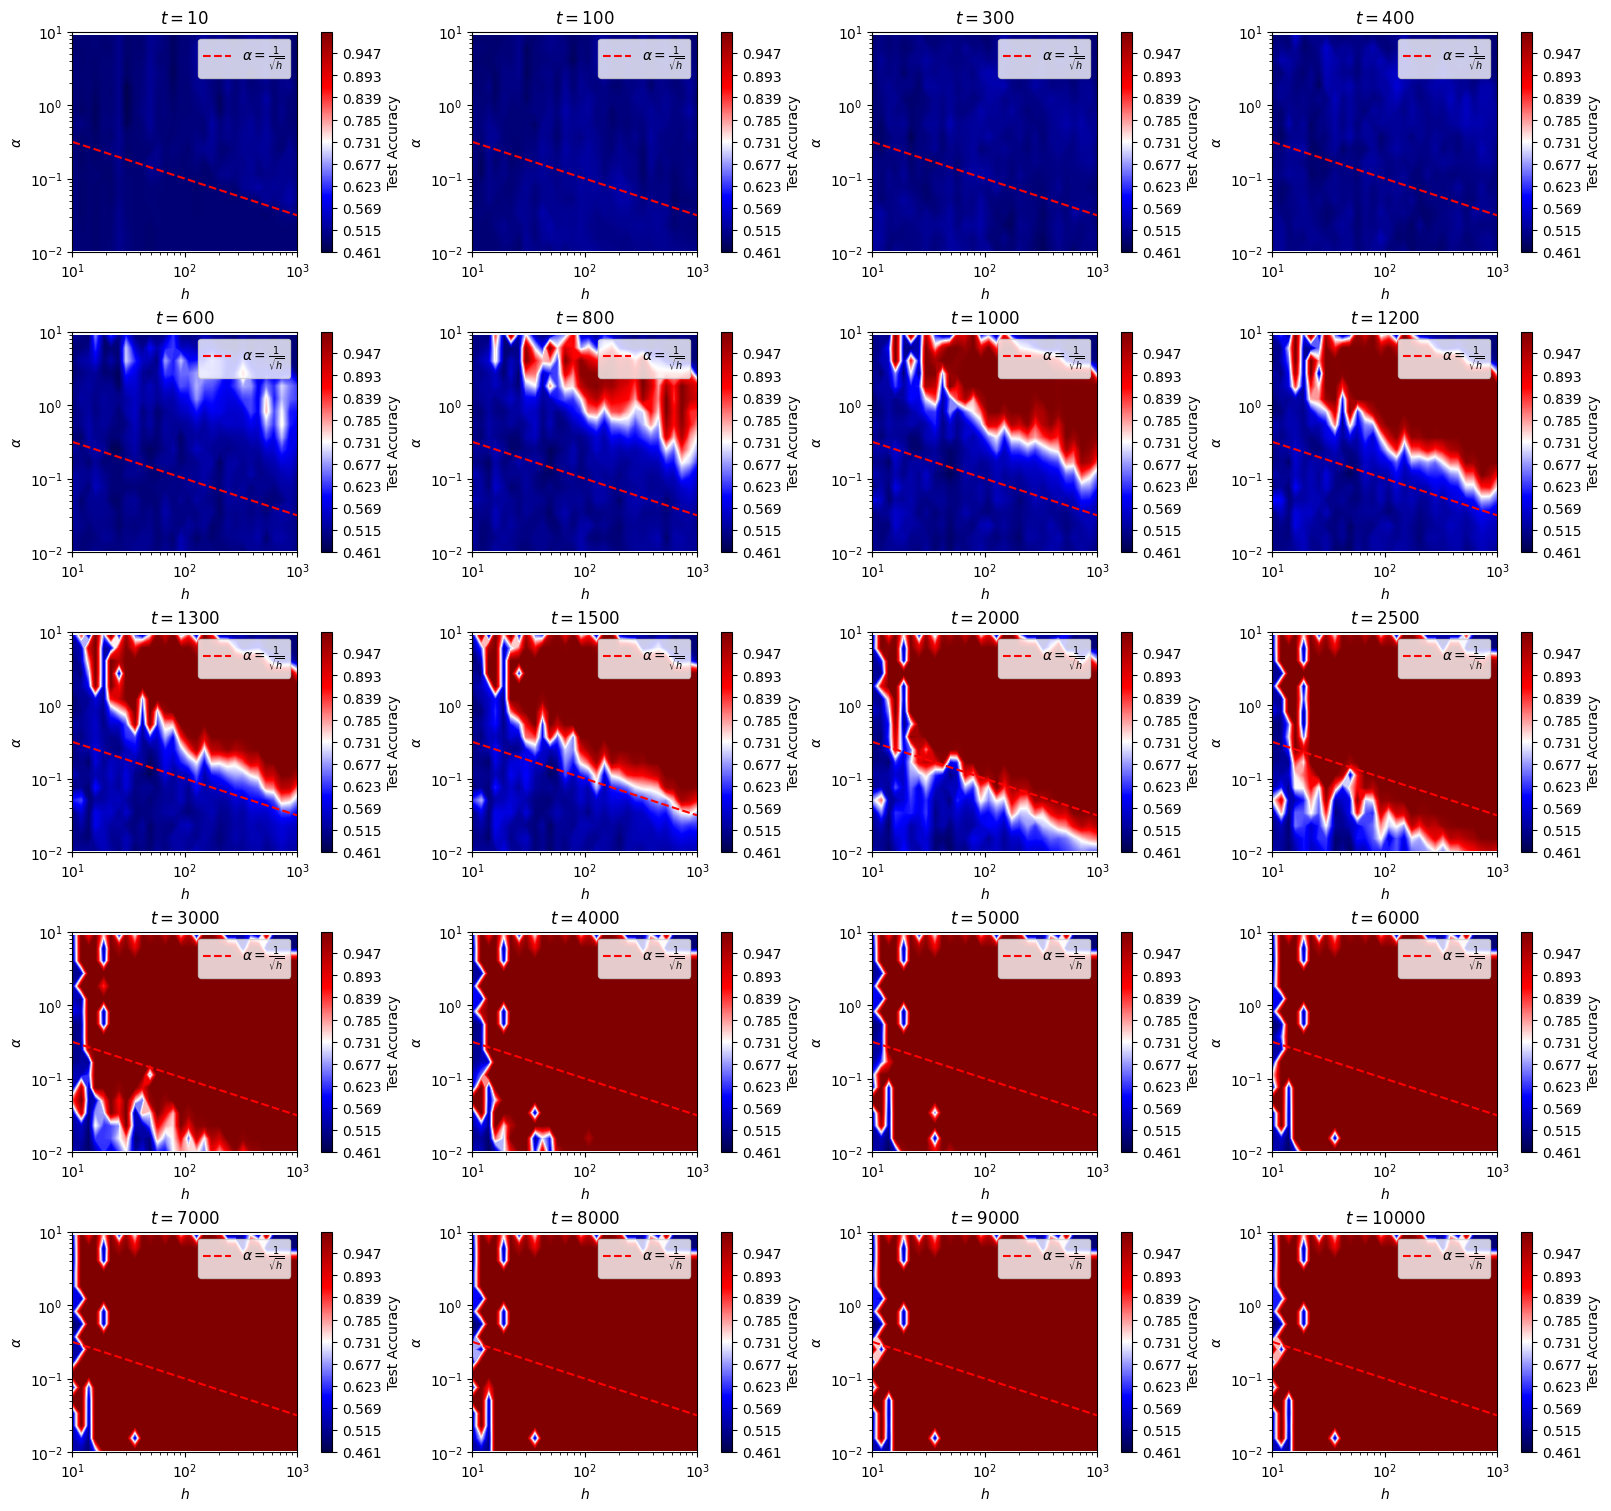

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def load_all_combination_data(directory):
    """指定されたディレクトリからすべてのデータファイルを読み込む"""
    all_data = []
    for filename in os.listdir(directory):
        if filename.startswith('combination_data_') and filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                all_data.append(data)
    return all_data

def plot_phase_diagram(all_data, steps_to_plot=None, unified_scale=False, plot_generalization_gap=False, scale_loss=False, plot_accuracy=False, plot_train_metrics=False, xlim=None, ylim=None):
    # hidden_sizes と alphas を抽出
    hidden_sizes = sorted(list(set(data['hidden_size'] for data in all_data)))
    alphas = sorted(list(set(data['alpha'] for data in all_data)))

    # xlim や ylim が指定された場合、対応する範囲のデータだけフィルタリング
    if xlim is not None:
        hidden_sizes = [h for h in hidden_sizes if xlim[0] <= h <= xlim[1]]
    if ylim is not None:
        alphas = [a for a in alphas if ylim[0] <= a <= ylim[1]]

    # step を取得
    all_steps = sorted(list(set(int(step) for data in all_data for step in data['test_losses'].keys())))

    if steps_to_plot is None:
        steps_to_plot = all_steps
    else:
        steps_to_plot = [step for step in steps_to_plot if step in all_steps]

    test_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}
    train_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}

    # メトリックを読み込み
    for data in all_data:
        i = hidden_sizes.index(data['hidden_size']) if data['hidden_size'] in hidden_sizes else None
        j = alphas.index(data['alpha']) if data['alpha'] in alphas else None
        if i is None or j is None:
            continue  # 範囲外のデータをスキップ
        for step in steps_to_plot:
            if str(step) in data['test_losses']:
                if plot_accuracy:
                    test_metric = data['test_accuracies'][str(step)]
                    train_metric = data['train_accuracies'][str(step)]
                else:
                    test_metric = data['test_losses'][str(step)]
                    train_metric = data['train_losses'][str(step)]

                if scale_loss and not plot_accuracy:
                    test_metric *= data['alpha'] ** 2
                    train_metric *= data['alpha'] ** 2

                test_metrics[step][i, j] = test_metric
                train_metrics[step][i, j] = train_metric

    # 統一スケールの設定
    if unified_scale:
        if plot_generalization_gap:
            all_min = min((test_metrics[step] - train_metrics[step]).min() for step in steps_to_plot)
            all_max = max((test_metrics[step] - train_metrics[step]).max() for step in steps_to_plot)
        else:
            all_min = min(test_metrics[step].min() for step in steps_to_plot)
            all_max = max(test_metrics[step].max() for step in steps_to_plot)
        levels = np.linspace(all_min, all_max, 500)
    else:
        levels = 100

    num_steps = len(steps_to_plot)
    num_cols = 4
    num_rows = (num_steps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), constrained_layout=True)

    for i, step in enumerate(steps_to_plot):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        if plot_generalization_gap:
            generalization_gap = test_metrics[step] - train_metrics[step]
            c = ax.contourf(hidden_sizes, alphas, generalization_gap.T, levels=levels, cmap='seismic')
            ax.set_title(f'$t = {step}$')
            fig.colorbar(c, ax=ax, label='Generalization Gap')
        else:
            if plot_train_metrics:
                c = ax.contourf(hidden_sizes, alphas, train_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Train Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Train Loss')
            else:
                c = ax.contourf(hidden_sizes, alphas, test_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Test Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Test Loss')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$h$')
        ax.set_ylabel(r'$\alpha$')

        # xlim, ylim の適用
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        # alpha = 1 / sqrt(h) の破線
        h_values = np.logspace(np.log10(hidden_sizes[0]), np.log10(hidden_sizes[-1]), num=500)
        alpha_values = 1 / np.sqrt(h_values)
        ax.plot(h_values, alpha_values, 'r--', label=r'$\alpha = \frac{1}{\sqrt{h}}$')
        ax.legend()

    # 空のサブプロットを削除
    if num_rows > 1:
        for j in range(num_steps, num_rows * num_cols):
            fig.delaxes(axes[j // num_cols, j % num_cols])
    else:
        for j in range(num_steps, num_cols):
            fig.delaxes(axes[j])

    plt.show()

# データの読み込みと描画
checkpoint_dir = 'test04_1'
all_data = load_all_combination_data(checkpoint_dir)
steps_to_plot = [10, 100, 300, 400, 600, 800, 1000, 1200, 1300, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plot_generalization_gap = 0
unified_scale = 1
scale_loss = 0
plot_accuracy = 1
plot_train_metrics = 0

# xlim と ylim を設定
xlim = (10**1, 10**3)  # x軸の範囲
ylim = (10**(-2), 10)  # y軸の範囲

plot_phase_diagram(all_data, steps_to_plot, unified_scale=unified_scale, plot_generalization_gap=plot_generalization_gap, scale_loss=scale_loss, plot_accuracy=plot_accuracy, plot_train_metrics=plot_train_metrics, xlim=xlim, ylim=ylim)

## Train Acc

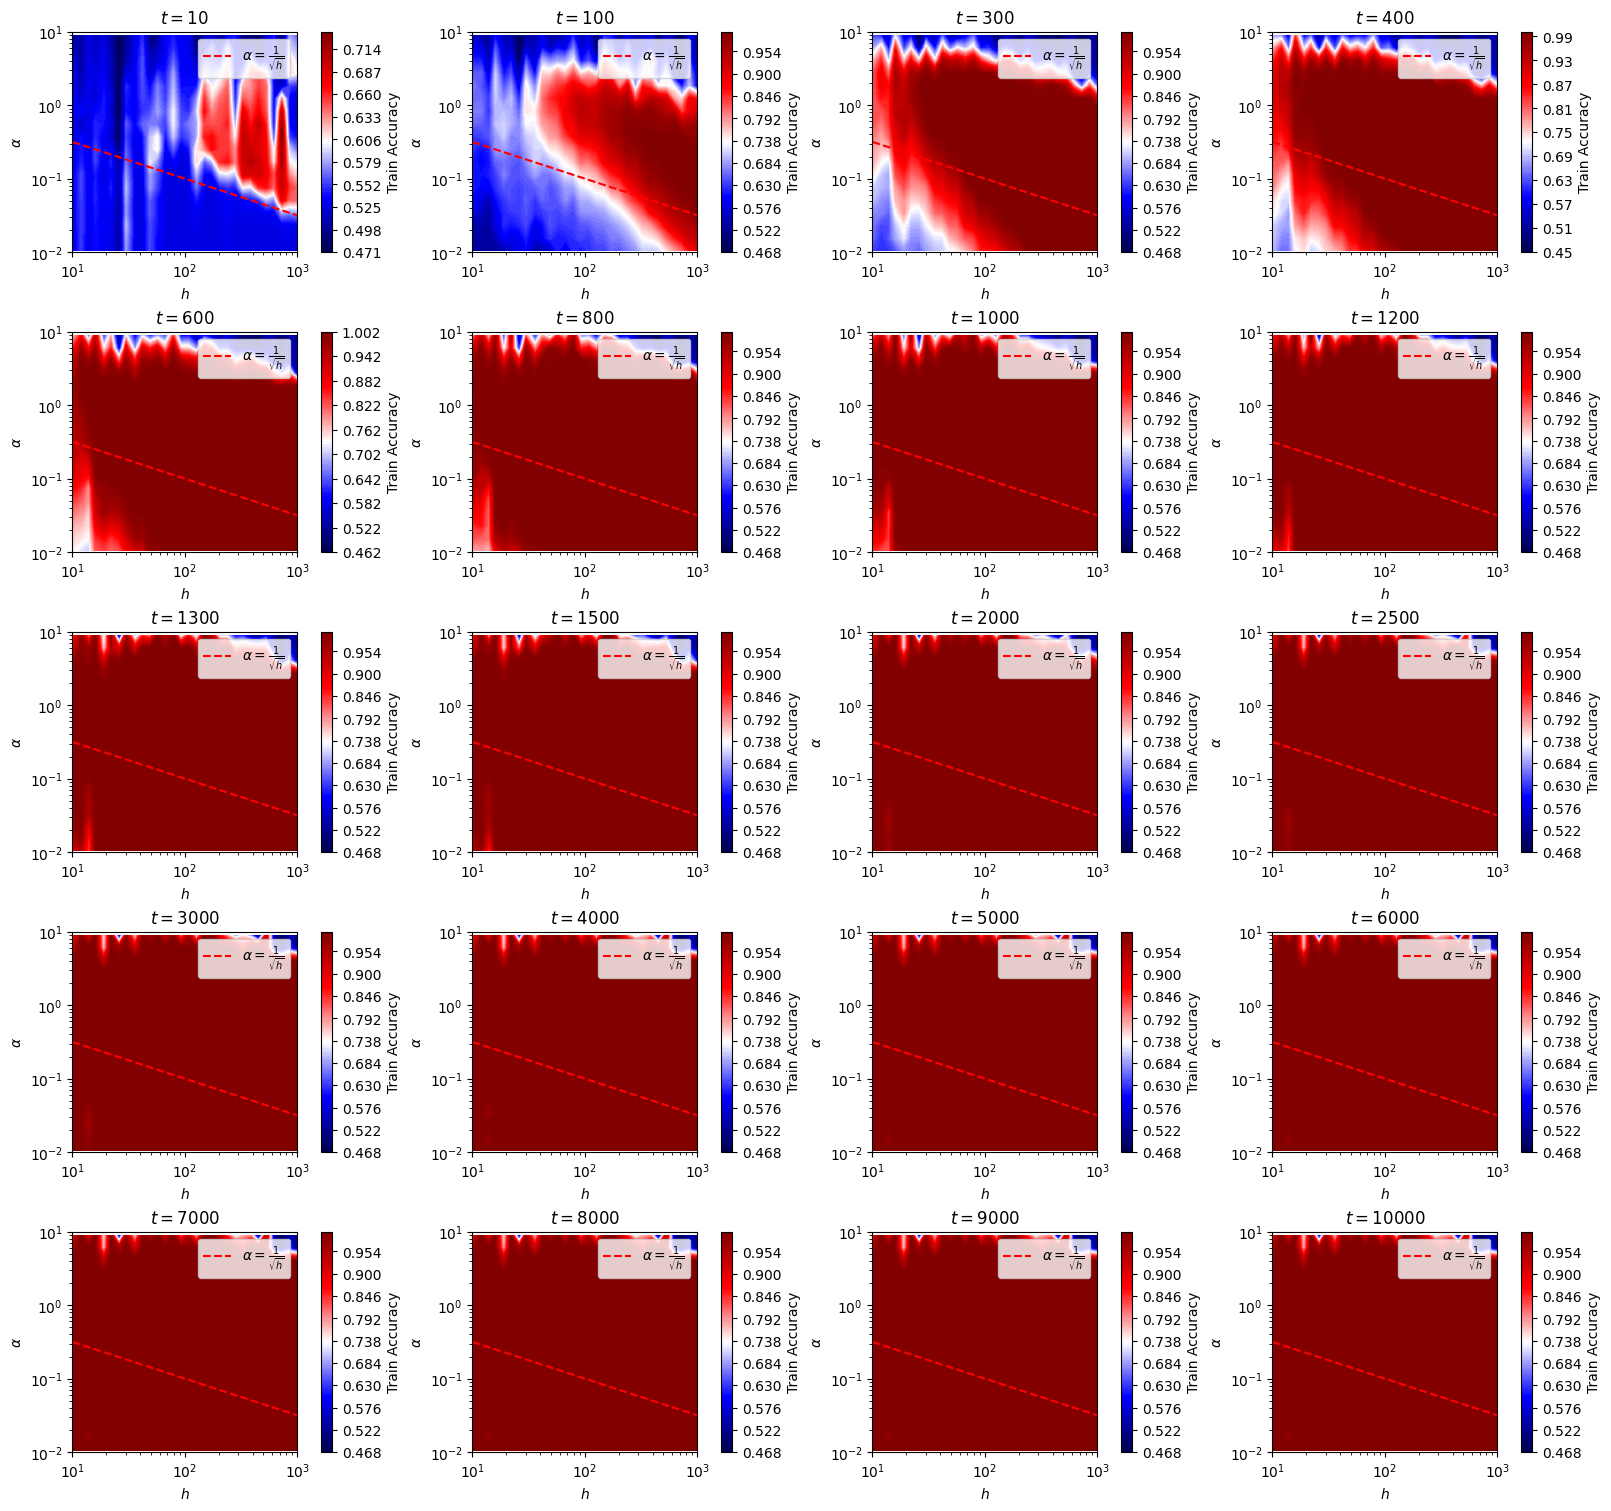

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def load_all_combination_data(directory):
    """指定されたディレクトリからすべてのデータファイルを読み込む"""
    all_data = []
    for filename in os.listdir(directory):
        if filename.startswith('combination_data_') and filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                all_data.append(data)
    return all_data

def plot_phase_diagram(all_data, steps_to_plot=None, unified_scale=False, plot_generalization_gap=False, scale_loss=False, plot_accuracy=False, plot_train_metrics=False, xlim=None, ylim=None):
    # hidden_sizes と alphas を抽出
    hidden_sizes = sorted(list(set(data['hidden_size'] for data in all_data)))
    alphas = sorted(list(set(data['alpha'] for data in all_data)))

    # xlim や ylim が指定された場合、対応する範囲のデータだけフィルタリング
    if xlim is not None:
        hidden_sizes = [h for h in hidden_sizes if xlim[0] <= h <= xlim[1]]
    if ylim is not None:
        alphas = [a for a in alphas if ylim[0] <= a <= ylim[1]]

    # step を取得
    all_steps = sorted(list(set(int(step) for data in all_data for step in data['test_losses'].keys())))

    if steps_to_plot is None:
        steps_to_plot = all_steps
    else:
        steps_to_plot = [step for step in steps_to_plot if step in all_steps]

    test_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}
    train_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}

    # メトリックを読み込み
    for data in all_data:
        i = hidden_sizes.index(data['hidden_size']) if data['hidden_size'] in hidden_sizes else None
        j = alphas.index(data['alpha']) if data['alpha'] in alphas else None
        if i is None or j is None:
            continue  # 範囲外のデータをスキップ
        for step in steps_to_plot:
            if str(step) in data['test_losses']:
                if plot_accuracy:
                    test_metric = data['test_accuracies'][str(step)]
                    train_metric = data['train_accuracies'][str(step)]
                else:
                    test_metric = data['test_losses'][str(step)]
                    train_metric = data['train_losses'][str(step)]

                if scale_loss and not plot_accuracy:
                    test_metric *= data['alpha'] ** 2
                    train_metric *= data['alpha'] ** 2

                test_metrics[step][i, j] = test_metric
                train_metrics[step][i, j] = train_metric

    # 統一スケールの設定
    if unified_scale:
        if plot_generalization_gap:
            all_min = min((test_metrics[step] - train_metrics[step]).min() for step in steps_to_plot)
            all_max = max((test_metrics[step] - train_metrics[step]).max() for step in steps_to_plot)
        else:
            all_min = min(test_metrics[step].min() for step in steps_to_plot)
            all_max = max(test_metrics[step].max() for step in steps_to_plot)
        levels = np.linspace(all_min, all_max, 500)
    else:
        levels = 100

    num_steps = len(steps_to_plot)
    num_cols = 4
    num_rows = (num_steps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), constrained_layout=True)

    for i, step in enumerate(steps_to_plot):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        if plot_generalization_gap:
            generalization_gap = test_metrics[step] - train_metrics[step]
            c = ax.contourf(hidden_sizes, alphas, generalization_gap.T, levels=levels, cmap='seismic')
            ax.set_title(f'$t = {step}$')
            fig.colorbar(c, ax=ax, label='Generalization Gap')
        else:
            if plot_train_metrics:
                c = ax.contourf(hidden_sizes, alphas, train_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Train Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Train Loss')
            else:
                c = ax.contourf(hidden_sizes, alphas, test_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Test Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Test Loss')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$h$')
        ax.set_ylabel(r'$\alpha$')

        # xlim, ylim の適用
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        # alpha = 1 / sqrt(h) の破線
        h_values = np.logspace(np.log10(hidden_sizes[0]), np.log10(hidden_sizes[-1]), num=500)
        alpha_values = 1 / np.sqrt(h_values)
        ax.plot(h_values, alpha_values, 'r--', label=r'$\alpha = \frac{1}{\sqrt{h}}$')
        ax.legend()

    # 空のサブプロットを削除
    if num_rows > 1:
        for j in range(num_steps, num_rows * num_cols):
            fig.delaxes(axes[j // num_cols, j % num_cols])
    else:
        for j in range(num_steps, num_cols):
            fig.delaxes(axes[j])

    plt.show()

# データの読み込みと描画
checkpoint_dir = 'test04_1'
all_data = load_all_combination_data(checkpoint_dir)
steps_to_plot = [10, 100, 300, 400, 600, 800, 1000, 1200, 1300, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plot_generalization_gap = 0
unified_scale = 0
scale_loss = 1
plot_accuracy = 1
plot_train_metrics = 1

# xlim と ylim を設定
xlim = (10**1, 10**3)  # x軸の範囲
ylim = (10**(-2), 10)  # y軸の範囲

plot_phase_diagram(all_data, steps_to_plot, unified_scale=unified_scale, plot_generalization_gap=plot_generalization_gap, scale_loss=scale_loss, plot_accuracy=plot_accuracy, plot_train_metrics=plot_train_metrics, xlim=xlim, ylim=ylim)

## Acc Gap

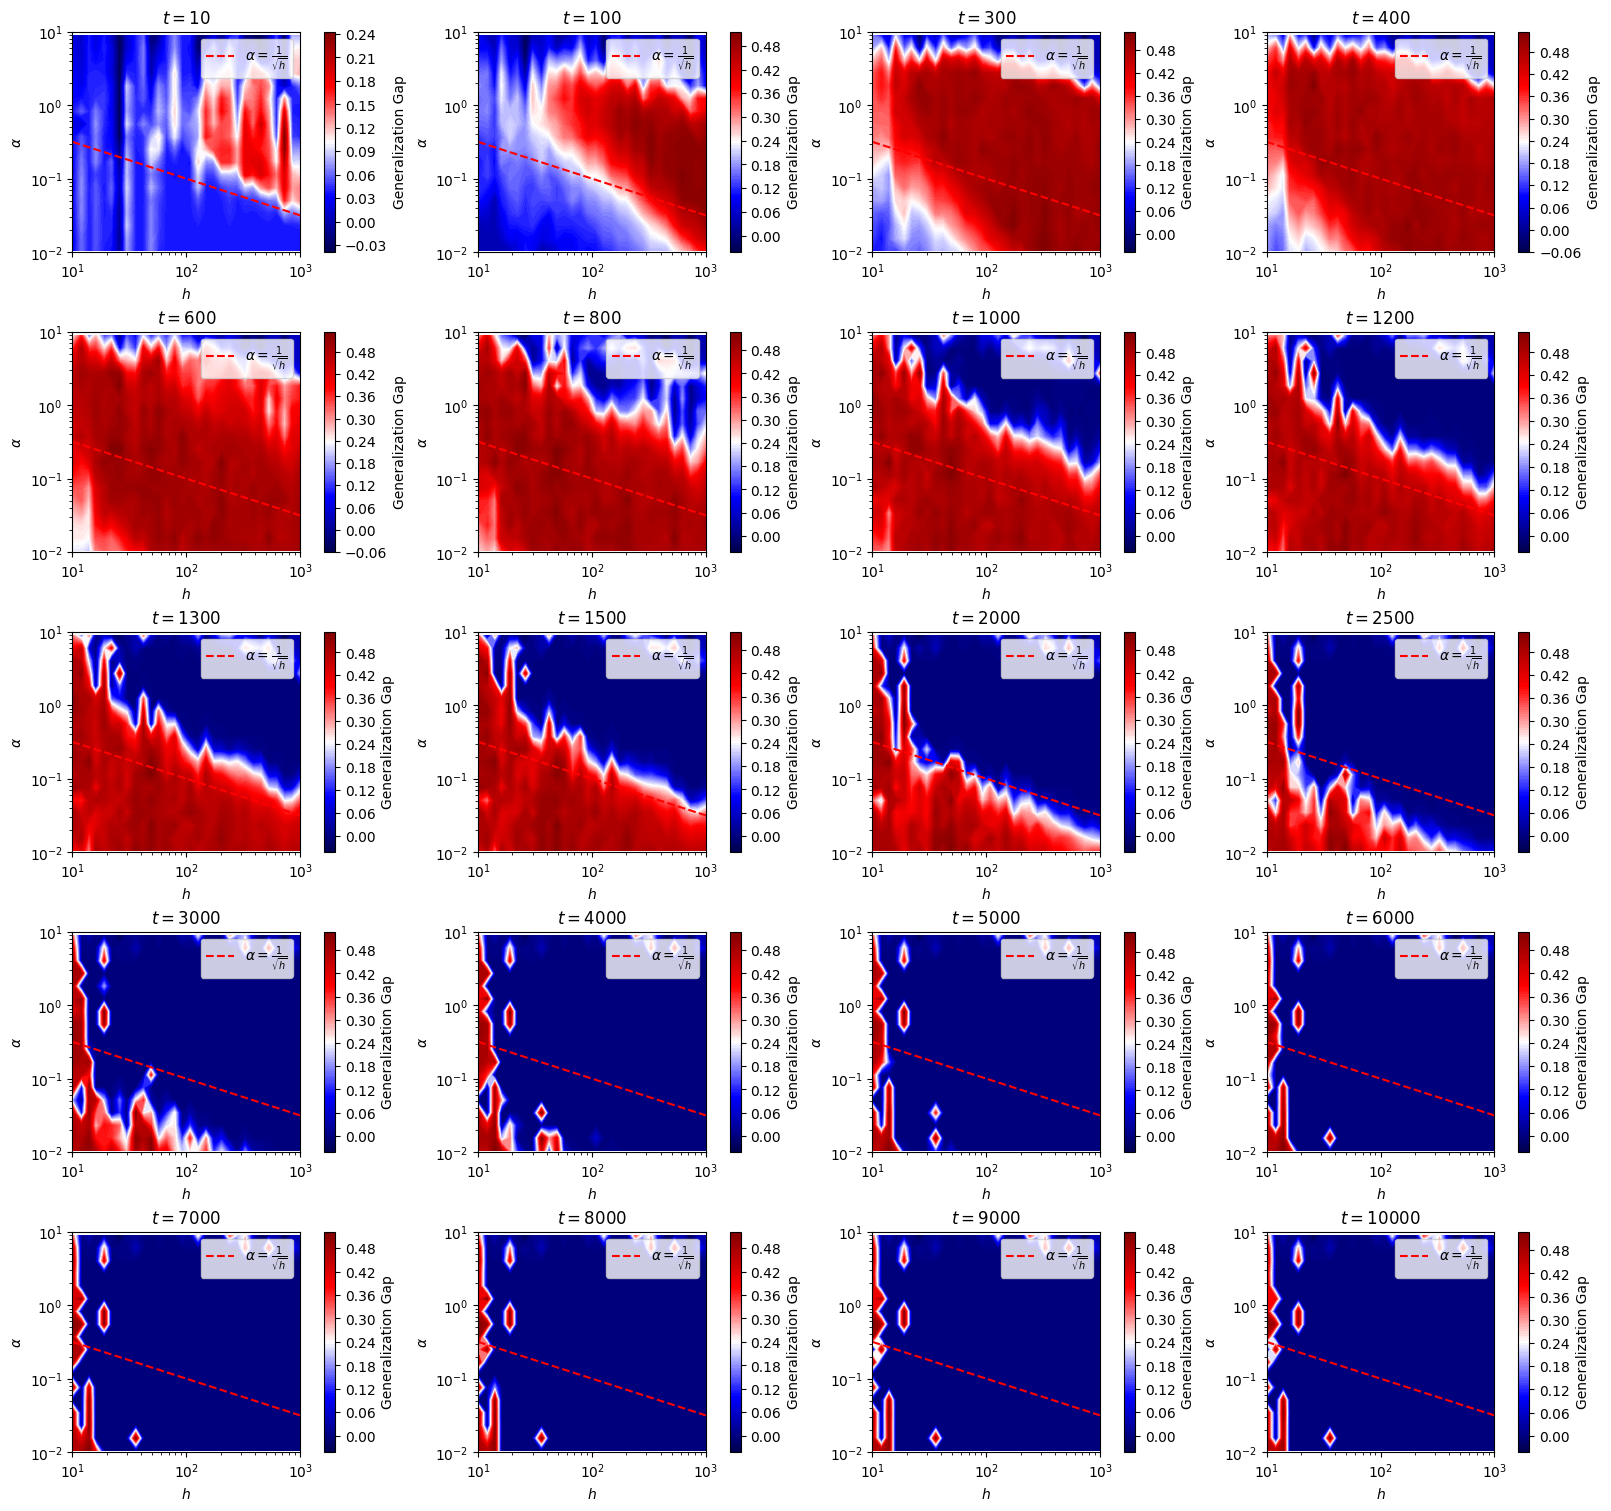

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def load_all_combination_data(directory):
    """指定されたディレクトリからすべてのデータファイルを読み込む"""
    all_data = []
    for filename in os.listdir(directory):
        if filename.startswith('combination_data_') and filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                all_data.append(data)
    return all_data

def plot_phase_diagram(all_data, steps_to_plot=None, unified_scale=False, plot_generalization_gap=False, scale_loss=False, plot_accuracy=False, plot_train_metrics=False, xlim=None, ylim=None):
    # hidden_sizes と alphas を抽出
    hidden_sizes = sorted(list(set(data['hidden_size'] for data in all_data)))
    alphas = sorted(list(set(data['alpha'] for data in all_data)))

    # xlim や ylim が指定された場合、対応する範囲のデータだけフィルタリング
    if xlim is not None:
        hidden_sizes = [h for h in hidden_sizes if xlim[0] <= h <= xlim[1]]
    if ylim is not None:
        alphas = [a for a in alphas if ylim[0] <= a <= ylim[1]]

    # step を取得
    all_steps = sorted(list(set(int(step) for data in all_data for step in data['test_losses'].keys())))

    if steps_to_plot is None:
        steps_to_plot = all_steps
    else:
        steps_to_plot = [step for step in steps_to_plot if step in all_steps]

    test_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}
    train_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}

    # メトリックを読み込み
    for data in all_data:
        i = hidden_sizes.index(data['hidden_size']) if data['hidden_size'] in hidden_sizes else None
        j = alphas.index(data['alpha']) if data['alpha'] in alphas else None
        if i is None or j is None:
            continue  # 範囲外のデータをスキップ
        for step in steps_to_plot:
            if str(step) in data['test_losses']:
                if plot_accuracy:
                    test_metric = data['test_accuracies'][str(step)]
                    train_metric = data['train_accuracies'][str(step)]
                else:
                    test_metric = data['test_losses'][str(step)]
                    train_metric = data['train_losses'][str(step)]

                if scale_loss and not plot_accuracy:
                    test_metric *= data['alpha'] ** 2
                    train_metric *= data['alpha'] ** 2

                test_metrics[step][i, j] = test_metric
                train_metrics[step][i, j] = train_metric

    # 統一スケールの設定
    if unified_scale:
        if plot_generalization_gap:
            all_min = min((test_metrics[step] - train_metrics[step]).min() for step in steps_to_plot)
            all_max = max((test_metrics[step] - train_metrics[step]).max() for step in steps_to_plot)
        else:
            all_min = min(test_metrics[step].min() for step in steps_to_plot)
            all_max = max(test_metrics[step].max() for step in steps_to_plot)
        levels = np.linspace(all_min, all_max, 500)
    else:
        levels = 100

    num_steps = len(steps_to_plot)
    num_cols = 4
    num_rows = (num_steps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), constrained_layout=True)

    for i, step in enumerate(steps_to_plot):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        if plot_generalization_gap:
            generalization_gap = train_metrics[step] - test_metrics[step]  ## Acc の Gap なので交換した
            c = ax.contourf(hidden_sizes, alphas, generalization_gap.T, levels=levels, cmap='seismic')
            ax.set_title(f'$t = {step}$')
            fig.colorbar(c, ax=ax, label='Generalization Gap')
        else:
            if plot_train_metrics:
                c = ax.contourf(hidden_sizes, alphas, train_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Train Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Train Loss')
            else:
                c = ax.contourf(hidden_sizes, alphas, test_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Test Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Test Loss')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$h$')
        ax.set_ylabel(r'$\alpha$')

        # xlim, ylim の適用
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        # alpha = 1 / sqrt(h) の破線
        h_values = np.logspace(np.log10(hidden_sizes[0]), np.log10(hidden_sizes[-1]), num=500)
        alpha_values = 1 / np.sqrt(h_values)
        ax.plot(h_values, alpha_values, 'r--', label=r'$\alpha = \frac{1}{\sqrt{h}}$')
        ax.legend()

    # 空のサブプロットを削除
    if num_rows > 1:
        for j in range(num_steps, num_rows * num_cols):
            fig.delaxes(axes[j // num_cols, j % num_cols])
    else:
        for j in range(num_steps, num_cols):
            fig.delaxes(axes[j])

    plt.show()

# データの読み込みと描画
checkpoint_dir = 'test04_1'
all_data = load_all_combination_data(checkpoint_dir)
steps_to_plot = [10, 100, 300, 400, 600, 800, 1000, 1200, 1300, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plot_generalization_gap = 1
unified_scale = 0
scale_loss = 0
plot_accuracy = 1
plot_train_metrics = 0

# xlim と ylim を設定
xlim = (10**1, 10**3)  # x軸の範囲
ylim = (10**(-2), 10)  # y軸の範囲

plot_phase_diagram(all_data, steps_to_plot, unified_scale=unified_scale, plot_generalization_gap=plot_generalization_gap, scale_loss=scale_loss, plot_accuracy=plot_accuracy, plot_train_metrics=plot_train_metrics, xlim=xlim, ylim=ylim)

## Test Loss

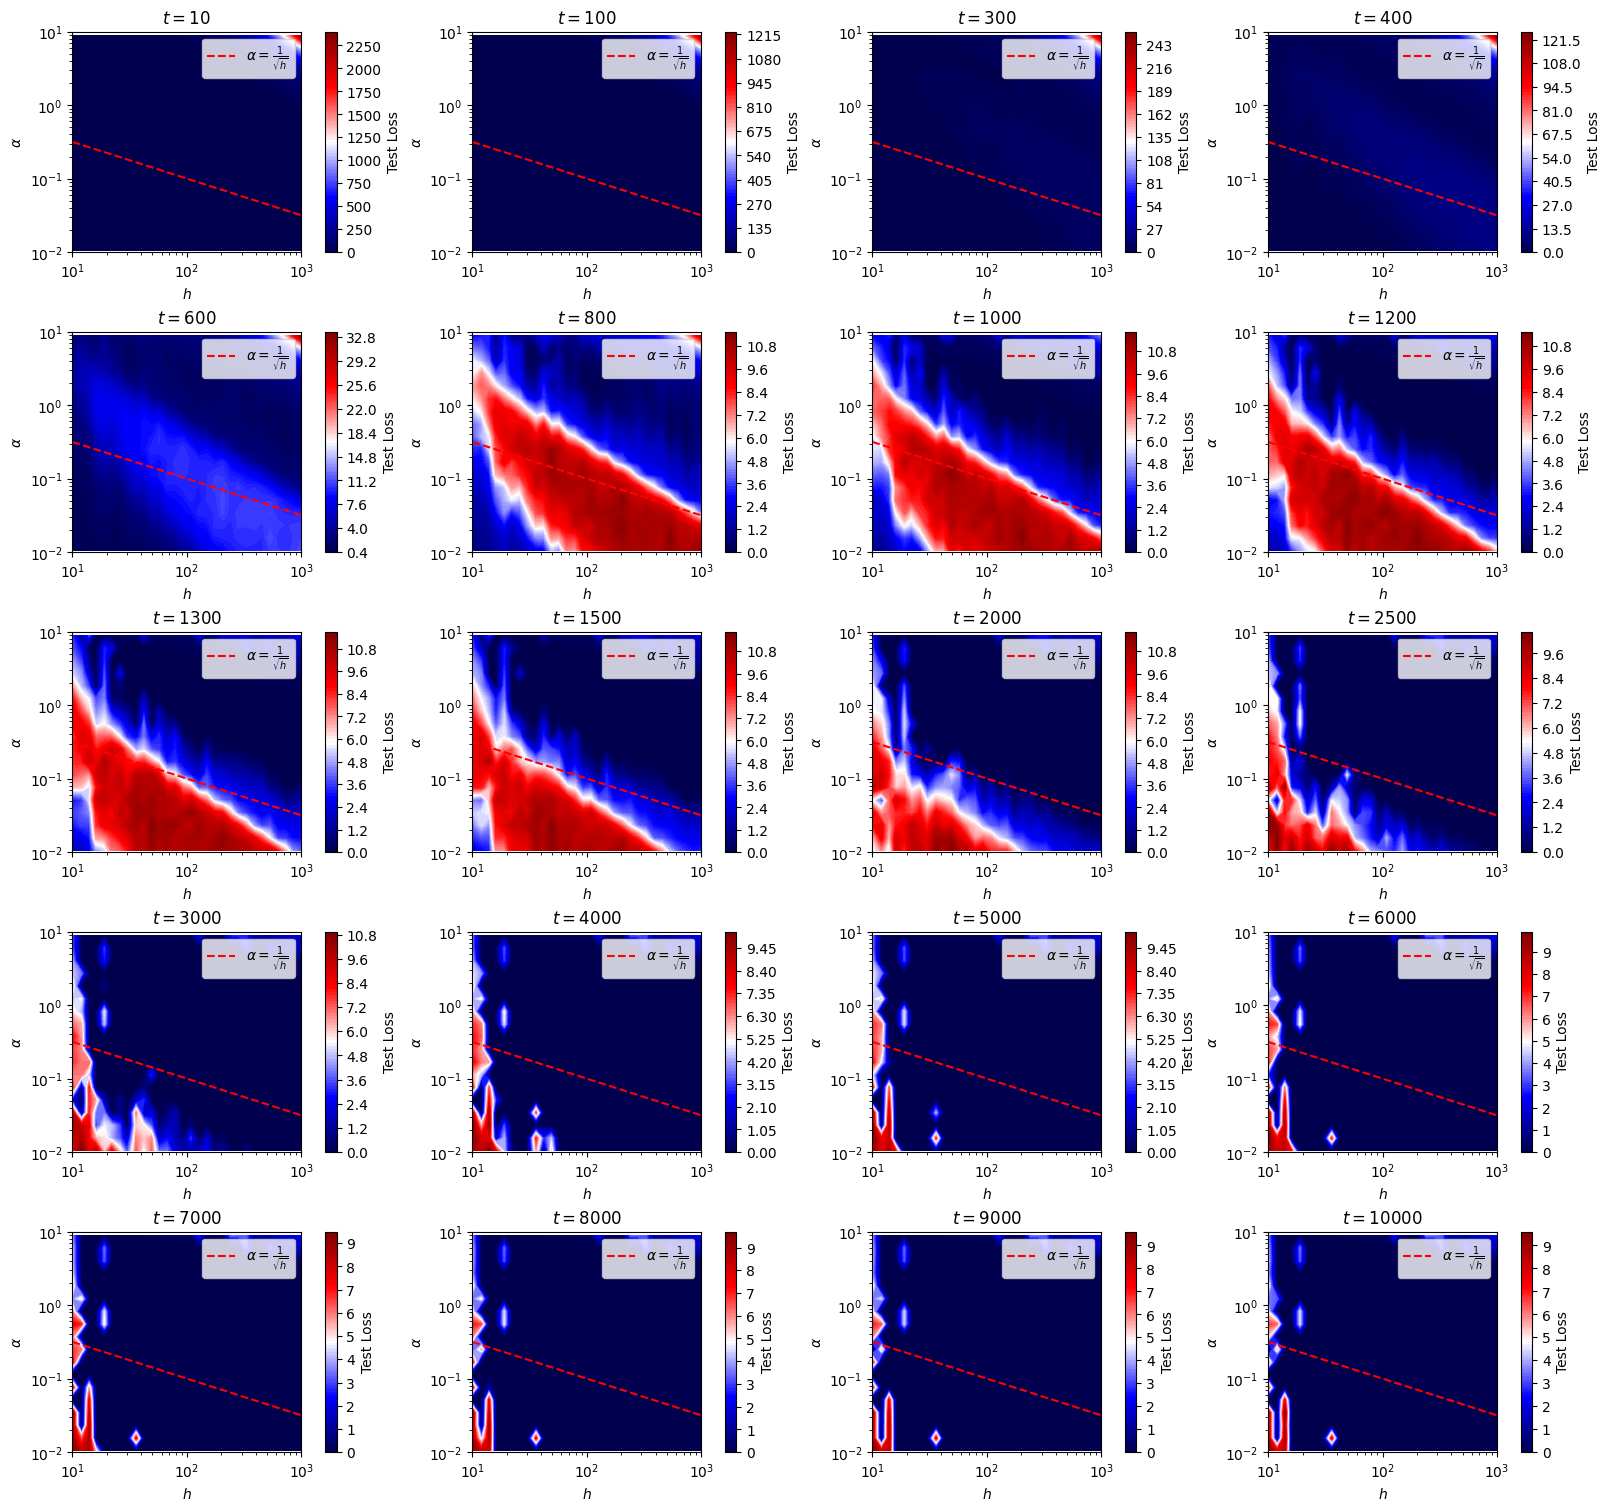

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def load_all_combination_data(directory):
    """指定されたディレクトリからすべてのデータファイルを読み込む"""
    all_data = []
    for filename in os.listdir(directory):
        if filename.startswith('combination_data_') and filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                all_data.append(data)
    return all_data

def plot_phase_diagram(all_data, steps_to_plot=None, unified_scale=False, plot_generalization_gap=False, scale_loss=False, plot_accuracy=False, plot_train_metrics=False, xlim=None, ylim=None):
    # hidden_sizes と alphas を抽出
    hidden_sizes = sorted(list(set(data['hidden_size'] for data in all_data)))
    alphas = sorted(list(set(data['alpha'] for data in all_data)))

    # xlim や ylim が指定された場合、対応する範囲のデータだけフィルタリング
    if xlim is not None:
        hidden_sizes = [h for h in hidden_sizes if xlim[0] <= h <= xlim[1]]
    if ylim is not None:
        alphas = [a for a in alphas if ylim[0] <= a <= ylim[1]]

    # step を取得
    all_steps = sorted(list(set(int(step) for data in all_data for step in data['test_losses'].keys())))

    if steps_to_plot is None:
        steps_to_plot = all_steps
    else:
        steps_to_plot = [step for step in steps_to_plot if step in all_steps]

    test_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}
    train_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}

    # メトリックを読み込み
    for data in all_data:
        i = hidden_sizes.index(data['hidden_size']) if data['hidden_size'] in hidden_sizes else None
        j = alphas.index(data['alpha']) if data['alpha'] in alphas else None
        if i is None or j is None:
            continue  # 範囲外のデータをスキップ
        for step in steps_to_plot:
            if str(step) in data['test_losses']:
                if plot_accuracy:
                    test_metric = data['test_accuracies'][str(step)]
                    train_metric = data['train_accuracies'][str(step)]
                else:
                    test_metric = data['test_losses'][str(step)]
                    train_metric = data['train_losses'][str(step)]

                if scale_loss and not plot_accuracy:
                    test_metric *= data['alpha'] ** 2
                    train_metric *= data['alpha'] ** 2

                test_metrics[step][i, j] = test_metric
                train_metrics[step][i, j] = train_metric

    # 統一スケールの設定
    if unified_scale:
        if plot_generalization_gap:
            all_min = min((test_metrics[step] - train_metrics[step]).min() for step in steps_to_plot)
            all_max = max((test_metrics[step] - train_metrics[step]).max() for step in steps_to_plot)
        else:
            all_min = min(test_metrics[step].min() for step in steps_to_plot)
            all_max = max(test_metrics[step].max() for step in steps_to_plot)
        levels = np.linspace(all_min, all_max, 500)
    else:
        levels = 100

    num_steps = len(steps_to_plot)
    num_cols = 4
    num_rows = (num_steps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), constrained_layout=True)

    for i, step in enumerate(steps_to_plot):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        if plot_generalization_gap:
            generalization_gap = test_metrics[step] - train_metrics[step]
            c = ax.contourf(hidden_sizes, alphas, generalization_gap.T, levels=levels, cmap='seismic')
            ax.set_title(f'$t = {step}$')
            fig.colorbar(c, ax=ax, label='Generalization Gap')
        else:
            if plot_train_metrics:
                c = ax.contourf(hidden_sizes, alphas, train_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Train Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Train Loss')
            else:
                c = ax.contourf(hidden_sizes, alphas, test_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Test Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Test Loss')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$h$')
        ax.set_ylabel(r'$\alpha$')

        # xlim, ylim の適用
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        # alpha = 1 / sqrt(h) の破線
        h_values = np.logspace(np.log10(hidden_sizes[0]), np.log10(hidden_sizes[-1]), num=500)
        alpha_values = 1 / np.sqrt(h_values)
        ax.plot(h_values, alpha_values, 'r--', label=r'$\alpha = \frac{1}{\sqrt{h}}$')
        ax.legend()

    # 空のサブプロットを削除
    if num_rows > 1:
        for j in range(num_steps, num_rows * num_cols):
            fig.delaxes(axes[j // num_cols, j % num_cols])
    else:
        for j in range(num_steps, num_cols):
            fig.delaxes(axes[j])

    plt.show()

# データの読み込みと描画
checkpoint_dir = 'test04_1'
all_data = load_all_combination_data(checkpoint_dir)
steps_to_plot = [10, 100, 300, 400, 600, 800, 1000, 1200, 1300, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plot_generalization_gap = 0
unified_scale = 0
scale_loss = 1
plot_accuracy = 0
plot_train_metrics = 0

# xlim と ylim を設定
xlim = (10**1, 10**3)  # x軸の範囲
ylim = (10**(-2), 10)  # y軸の範囲

plot_phase_diagram(all_data, steps_to_plot, unified_scale=unified_scale, plot_generalization_gap=plot_generalization_gap, scale_loss=scale_loss, plot_accuracy=plot_accuracy, plot_train_metrics=plot_train_metrics, xlim=xlim, ylim=ylim)

## Train Loss

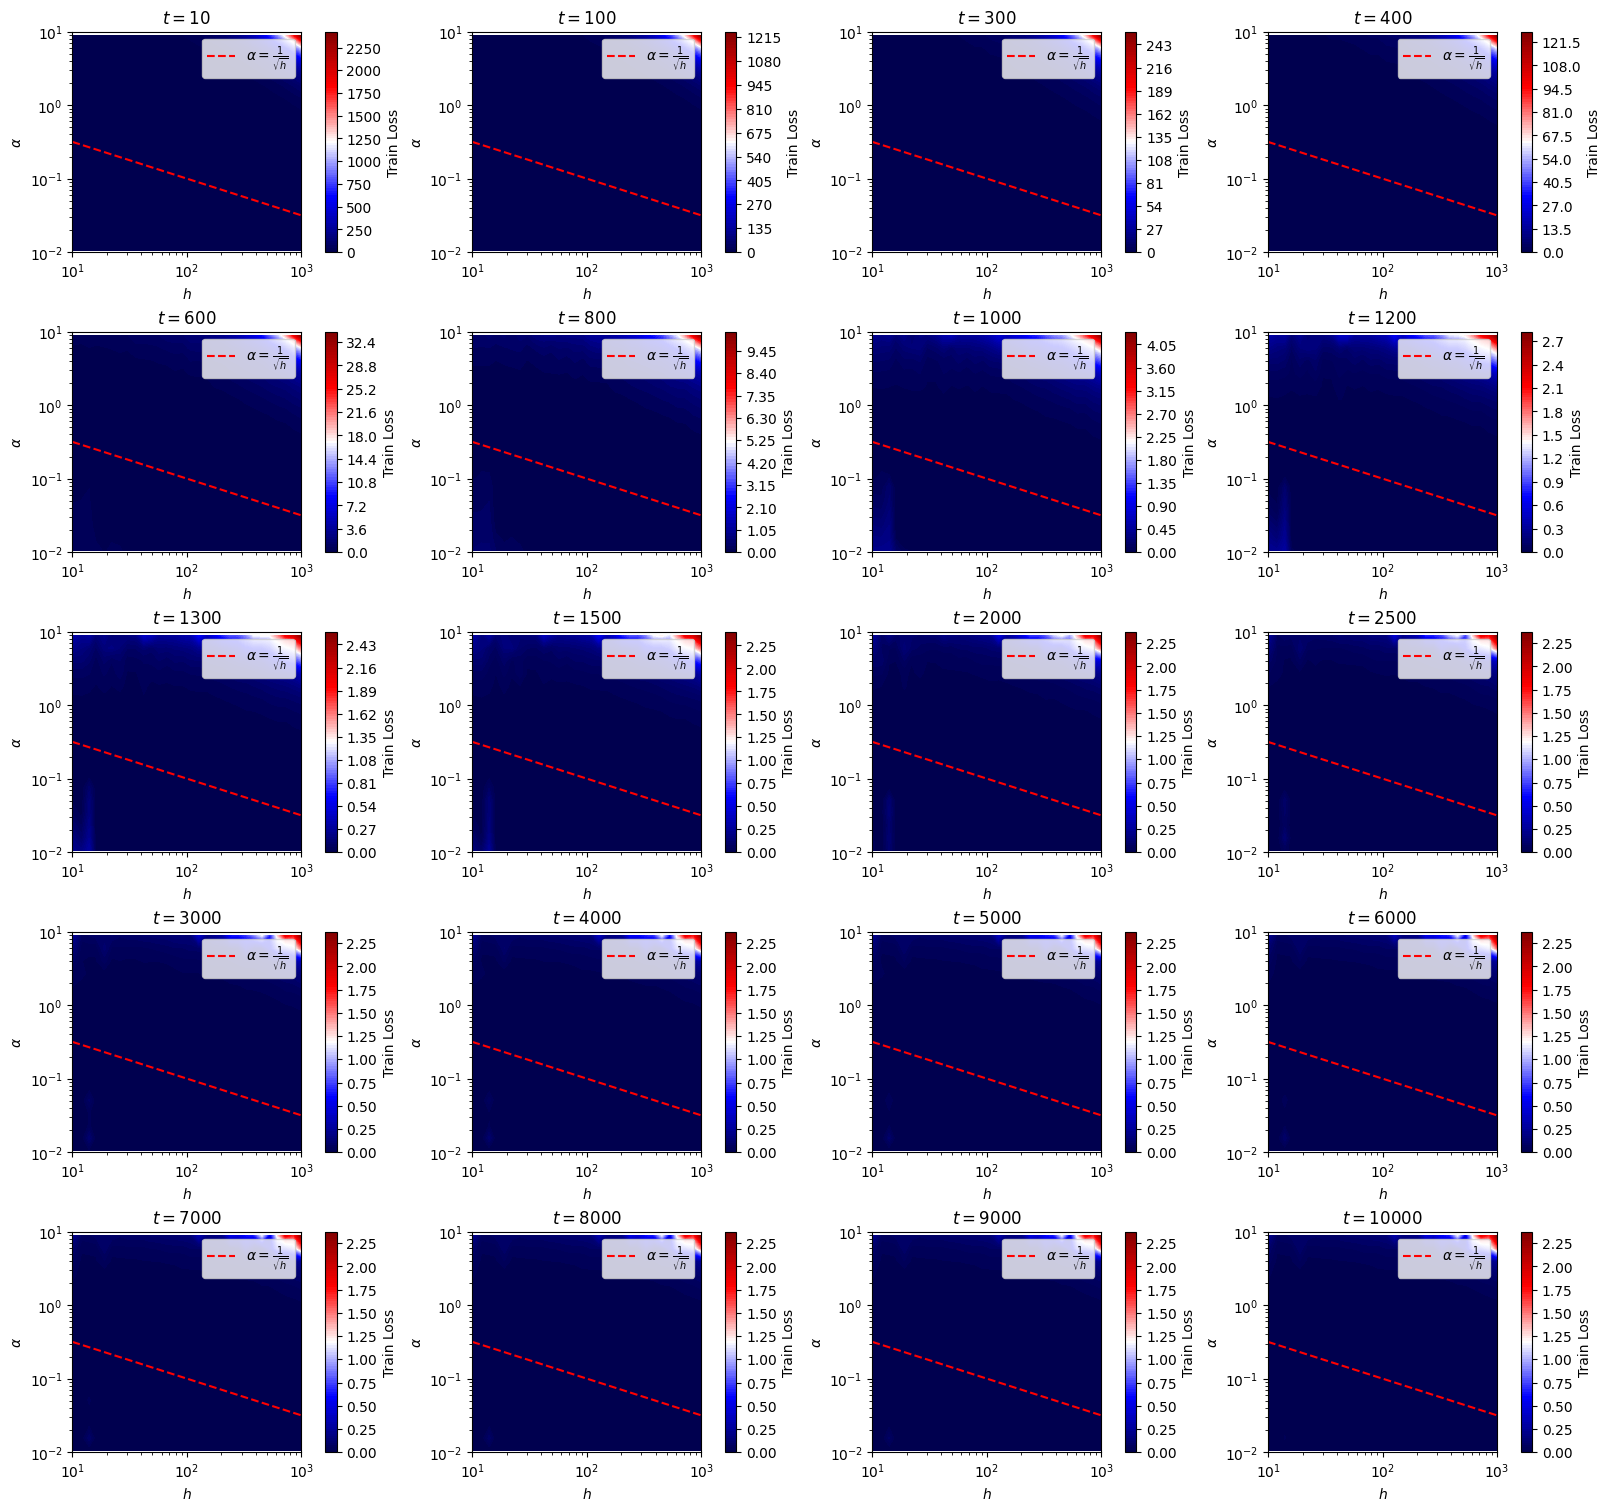

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def load_all_combination_data(directory):
    """指定されたディレクトリからすべてのデータファイルを読み込む"""
    all_data = []
    for filename in os.listdir(directory):
        if filename.startswith('combination_data_') and filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                all_data.append(data)
    return all_data

def plot_phase_diagram(all_data, steps_to_plot=None, unified_scale=False, plot_generalization_gap=False, scale_loss=False, plot_accuracy=False, plot_train_metrics=False, xlim=None, ylim=None):
    # hidden_sizes と alphas を抽出
    hidden_sizes = sorted(list(set(data['hidden_size'] for data in all_data)))
    alphas = sorted(list(set(data['alpha'] for data in all_data)))

    # xlim や ylim が指定された場合、対応する範囲のデータだけフィルタリング
    if xlim is not None:
        hidden_sizes = [h for h in hidden_sizes if xlim[0] <= h <= xlim[1]]
    if ylim is not None:
        alphas = [a for a in alphas if ylim[0] <= a <= ylim[1]]

    # step を取得
    all_steps = sorted(list(set(int(step) for data in all_data for step in data['test_losses'].keys())))

    if steps_to_plot is None:
        steps_to_plot = all_steps
    else:
        steps_to_plot = [step for step in steps_to_plot if step in all_steps]

    test_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}
    train_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}

    # メトリックを読み込み
    for data in all_data:
        i = hidden_sizes.index(data['hidden_size']) if data['hidden_size'] in hidden_sizes else None
        j = alphas.index(data['alpha']) if data['alpha'] in alphas else None
        if i is None or j is None:
            continue  # 範囲外のデータをスキップ
        for step in steps_to_plot:
            if str(step) in data['test_losses']:
                if plot_accuracy:
                    test_metric = data['test_accuracies'][str(step)]
                    train_metric = data['train_accuracies'][str(step)]
                else:
                    test_metric = data['test_losses'][str(step)]
                    train_metric = data['train_losses'][str(step)]

                if scale_loss and not plot_accuracy:
                    test_metric *= data['alpha'] ** 2
                    train_metric *= data['alpha'] ** 2

                test_metrics[step][i, j] = test_metric
                train_metrics[step][i, j] = train_metric

    # 統一スケールの設定
    if unified_scale:
        if plot_generalization_gap:
            all_min = min((test_metrics[step] - train_metrics[step]).min() for step in steps_to_plot)
            all_max = max((test_metrics[step] - train_metrics[step]).max() for step in steps_to_plot)
        else:
            all_min = min(test_metrics[step].min() for step in steps_to_plot)
            all_max = max(test_metrics[step].max() for step in steps_to_plot)
        levels = np.linspace(all_min, all_max, 500)
    else:
        levels = 100

    num_steps = len(steps_to_plot)
    num_cols = 4
    num_rows = (num_steps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), constrained_layout=True)

    for i, step in enumerate(steps_to_plot):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        if plot_generalization_gap:
            generalization_gap = test_metrics[step] - train_metrics[step]
            c = ax.contourf(hidden_sizes, alphas, generalization_gap.T, levels=levels, cmap='seismic')
            ax.set_title(f'$t = {step}$')
            fig.colorbar(c, ax=ax, label='Generalization Gap')
        else:
            if plot_train_metrics:
                c = ax.contourf(hidden_sizes, alphas, train_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Train Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Train Loss')
            else:
                c = ax.contourf(hidden_sizes, alphas, test_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Test Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Test Loss')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$h$')
        ax.set_ylabel(r'$\alpha$')

        # xlim, ylim の適用
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        # alpha = 1 / sqrt(h) の破線
        h_values = np.logspace(np.log10(hidden_sizes[0]), np.log10(hidden_sizes[-1]), num=500)
        alpha_values = 1 / np.sqrt(h_values)
        ax.plot(h_values, alpha_values, 'r--', label=r'$\alpha = \frac{1}{\sqrt{h}}$')
        ax.legend()

    # 空のサブプロットを削除
    if num_rows > 1:
        for j in range(num_steps, num_rows * num_cols):
            fig.delaxes(axes[j // num_cols, j % num_cols])
    else:
        for j in range(num_steps, num_cols):
            fig.delaxes(axes[j])

    plt.show()

# データの読み込みと描画
checkpoint_dir = 'test04_1'
all_data = load_all_combination_data(checkpoint_dir)
steps_to_plot = [10, 100, 300, 400, 600, 800, 1000, 1200, 1300, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plot_generalization_gap = 0
unified_scale = 0
scale_loss = 1
plot_accuracy = 0
plot_train_metrics = 1

# xlim と ylim を設定
xlim = (10**1, 10**3)  # x軸の範囲
ylim = (10**(-2), 10**(1))  # y軸の範囲

plot_phase_diagram(all_data, steps_to_plot, unified_scale=unified_scale, plot_generalization_gap=plot_generalization_gap, scale_loss=scale_loss, plot_accuracy=plot_accuracy, plot_train_metrics=plot_train_metrics, xlim=xlim, ylim=ylim)

## Loss Gap

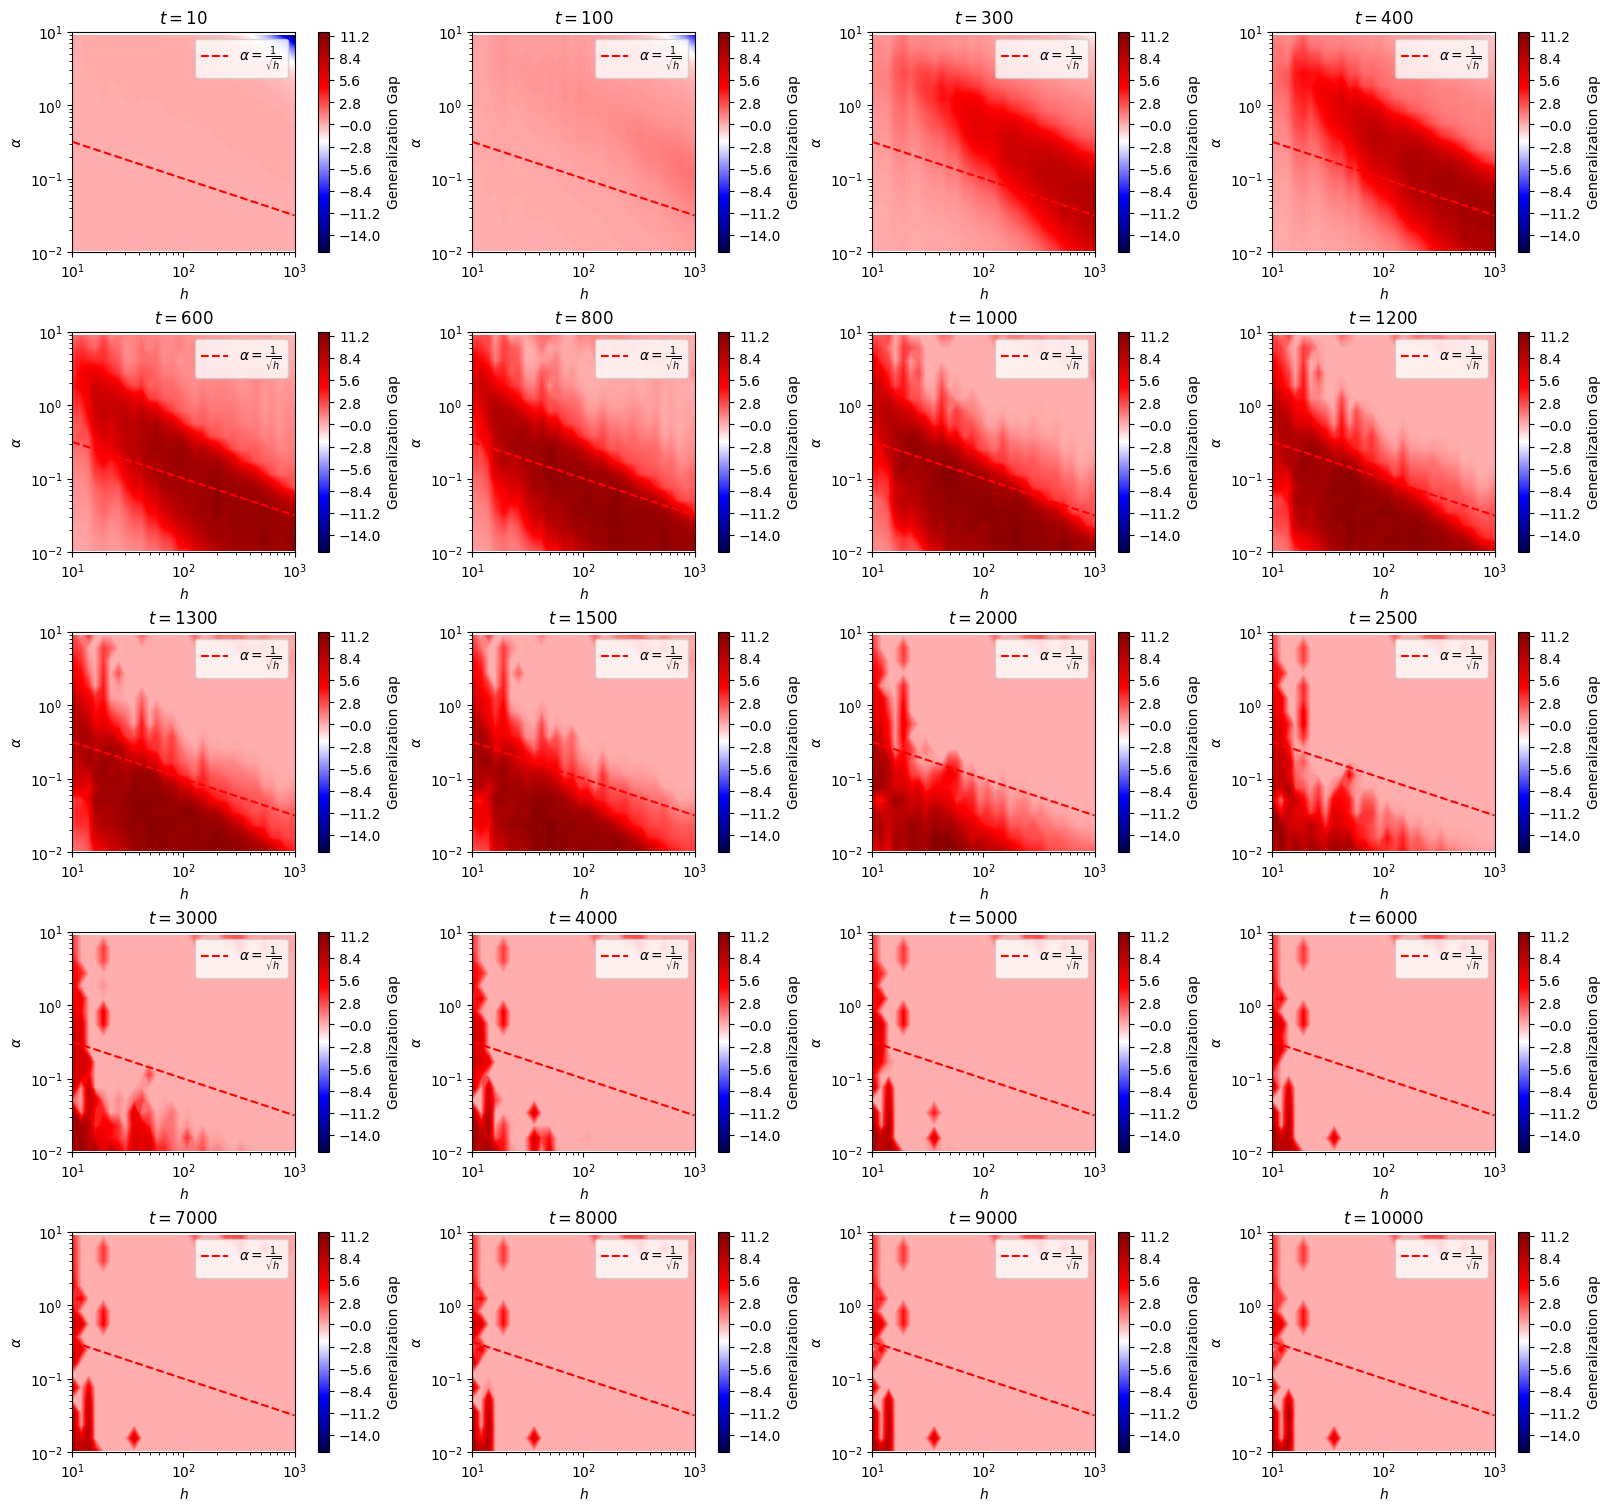

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def load_all_combination_data(directory):
    """指定されたディレクトリからすべてのデータファイルを読み込む"""
    all_data = []
    for filename in os.listdir(directory):
        if filename.startswith('combination_data_') and filename.endswith('.json'):
            with open(os.path.join(directory, filename), 'r') as f:
                data = json.load(f)
                all_data.append(data)
    return all_data

def plot_phase_diagram(all_data, steps_to_plot=None, unified_scale=False, plot_generalization_gap=False, scale_loss=False, plot_accuracy=False, plot_train_metrics=False, xlim=None, ylim=None):
    # hidden_sizes と alphas を抽出
    hidden_sizes = sorted(list(set(data['hidden_size'] for data in all_data)))
    alphas = sorted(list(set(data['alpha'] for data in all_data)))

    # xlim や ylim が指定された場合、対応する範囲のデータだけフィルタリング
    if xlim is not None:
        hidden_sizes = [h for h in hidden_sizes if xlim[0] <= h <= xlim[1]]
    if ylim is not None:
        alphas = [a for a in alphas if ylim[0] <= a <= ylim[1]]

    # step を取得
    all_steps = sorted(list(set(int(step) for data in all_data for step in data['test_losses'].keys())))

    if steps_to_plot is None:
        steps_to_plot = all_steps
    else:
        steps_to_plot = [step for step in steps_to_plot if step in all_steps]

    test_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}
    train_metrics = {step: np.zeros((len(hidden_sizes), len(alphas))) for step in steps_to_plot}

    # メトリックを読み込み
    for data in all_data:
        i = hidden_sizes.index(data['hidden_size']) if data['hidden_size'] in hidden_sizes else None
        j = alphas.index(data['alpha']) if data['alpha'] in alphas else None
        if i is None or j is None:
            continue  # 範囲外のデータをスキップ
        for step in steps_to_plot:
            if str(step) in data['test_losses']:
                if plot_accuracy:
                    test_metric = data['test_accuracies'][str(step)]
                    train_metric = data['train_accuracies'][str(step)]
                else:
                    test_metric = data['test_losses'][str(step)]
                    train_metric = data['train_losses'][str(step)]

                if scale_loss and not plot_accuracy:
                    test_metric *= data['alpha'] ** 2
                    train_metric *= data['alpha'] ** 2

                test_metrics[step][i, j] = test_metric
                train_metrics[step][i, j] = train_metric

    # 統一スケールの設定
    if unified_scale:
        if plot_generalization_gap:
            all_min = min((test_metrics[step] - train_metrics[step]).min() for step in steps_to_plot)
            all_max = max((test_metrics[step] - train_metrics[step]).max() for step in steps_to_plot)
        else:
            all_min = min(test_metrics[step].min() for step in steps_to_plot)
            all_max = max(test_metrics[step].max() for step in steps_to_plot)
        levels = np.linspace(all_min, all_max, 500)
    else:
        levels = 100

    num_steps = len(steps_to_plot)
    num_cols = 4
    num_rows = (num_steps + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows), constrained_layout=True)

    for i, step in enumerate(steps_to_plot):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col] if num_rows > 1 else axes[col]

        if plot_generalization_gap:
            generalization_gap = test_metrics[step] - train_metrics[step]
            c = ax.contourf(hidden_sizes, alphas, generalization_gap.T, levels=levels, cmap='seismic')
            ax.set_title(f'$t = {step}$')
            fig.colorbar(c, ax=ax, label='Generalization Gap')
        else:
            if plot_train_metrics:
                c = ax.contourf(hidden_sizes, alphas, train_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Train Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Train Loss')
            else:
                c = ax.contourf(hidden_sizes, alphas, test_metrics[step].T, levels=levels, cmap='seismic')
                ax.set_title(f'$t = {step}$')
                if plot_accuracy:
                    fig.colorbar(c, ax=ax, label='Test Accuracy')
                else:
                    fig.colorbar(c, ax=ax, label='Test Loss')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$h$')
        ax.set_ylabel(r'$\alpha$')

        # xlim, ylim の適用
        if xlim is not None:
            ax.set_xlim(xlim)
        if ylim is not None:
            ax.set_ylim(ylim)

        # alpha = 1 / sqrt(h) の破線
        h_values = np.logspace(np.log10(hidden_sizes[0]), np.log10(hidden_sizes[-1]), num=500)
        alpha_values = 1 / np.sqrt(h_values)
        ax.plot(h_values, alpha_values, 'r--', label=r'$\alpha = \frac{1}{\sqrt{h}}$')
        ax.legend()

    # 空のサブプロットを削除
    if num_rows > 1:
        for j in range(num_steps, num_rows * num_cols):
            fig.delaxes(axes[j // num_cols, j % num_cols])
    else:
        for j in range(num_steps, num_cols):
            fig.delaxes(axes[j])

    plt.show()

# データの読み込みと描画
checkpoint_dir = 'test04_1'
all_data = load_all_combination_data(checkpoint_dir)
steps_to_plot = [10, 100, 300, 400, 600, 800, 1000, 1200, 1300, 1500, 2000, 2500, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
plot_generalization_gap = 1
unified_scale = 1
scale_loss = 1
plot_accuracy = 0
plot_train_metrics = 0

# xlim と ylim を設定
xlim = (10**1, 10**3)  # x軸の範囲
ylim = (10**(-2), 10)  # y軸の範囲

plot_phase_diagram(all_data, steps_to_plot, unified_scale=unified_scale, plot_generalization_gap=plot_generalization_gap, scale_loss=scale_loss, plot_accuracy=plot_accuracy, plot_train_metrics=plot_train_metrics, xlim=xlim, ylim=ylim)